In [2]:
pip install sportsreference

     |████████████████████████████████| 472 kB 718 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import poisson


from sportsreference.nfl.teams import Teams
from sportsreference.nfl.boxscore import Boxscore
from sportsreference.nfl.roster import Player
from tqdm import tqdm

In [4]:
##data from https://www.advancedsportsanalytics.com/nfl-raw-data
import os
os.chdir('/Users/allisonkruse/desktop/nfl')
os.getcwd()

'/Users/allisonkruse/Desktop/nfl'

Get Data 

In [7]:
path = '/Users/allisonkruse/desktop/nfl/nfl_pass_rush_receive_raw_data.csv'
df = pd.read_csv(path)
pdp = pd.DataFrame(df)
pdp.head()

,game_id,player_id,pos,player,team,pass_cmp,pass_att,pass_yds,pass_td,pass_int,...,Surface,Temperature,Humidity,Wind_Speed,Vegas_Line,Vegas_Favorite,Over_Under,game_date,game_year,season
0,202009100kan,WatsDe00,QB,Deshaun Watson,HOU,20,32,253,1,1,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
1,202009100kan,JohnDa08,RB,David Johnson,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
2,202009100kan,JohnDu00,RB,Duke Johnson,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
3,202009100kan,FullWi01,WR,Will Fuller,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
4,202009100kan,AkinJo00,TE,Jordan Akins,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020


filter down to player, touchdowns and last few seasons

In [8]:
## get list of all column names
col_list = pdp.columns.values.tolist()

print (col_list)

['game_id', 'player_id', 'pos', 'player', 'team', 'pass_cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'pass_sacked', 'pass_sacked_yds', 'pass_long', 'pass_rating', 'rush_att', 'rush_yds', 'rush_td', 'rush_long', 'targets', 'rec', 'rec_yds', 'rec_td', 'rec_long', 'fumbles_lost', 'rush_scrambles', 'designed_rush_att', 'comb_pass_rush_play', 'comb_pass_play', 'comb_rush_play', 'Team_abbrev', 'Opponent_abbrev', 'game_id_copy', 'two_point_conv', 'total_ret_td', 'offensive_fumble_recovery_td', 'pass_yds_bonus', 'rush_yds_bonus', 'rec_yds_bonus', 'Total_DKP', 'Off_DKP', 'Total_FDP', 'Off_FDP', 'Total_SDP', 'Off_SDP', 'pass_target_yds', 'pass_poor_throws', 'pass_blitzed', 'pass_hurried', 'rush_yds_before_contact', 'rush_yac', 'rush_broken_tackles', 'rec_air_yds', 'rec_yac', 'rec_drops', 'offense', 'off_pct', 'vis_team', 'home_team', 'vis_score', 'home_score', 'OT', 'Roof', 'Surface', 'Temperature', 'Humidity', 'Wind_Speed', 'Vegas_Line', 'Vegas_Favorite', 'Over_Under', 'game_date', 'gam

In [9]:
##hitting a key index error on season 
pdp.get('season')

0        2020
1        2020
2        2020
3        2020
4        2020
         ... 
19485    2022
19486    2022
19487    2022
19488    2022
19489    2022
Name: season, Length: 19490, dtype: int64

In [10]:
##reindex data to correct 
newdf = pdp.reindex()

In [11]:
newdf.head()

,game_id,player_id,pos,player,team,pass_cmp,pass_att,pass_yds,pass_td,pass_int,...,Surface,Temperature,Humidity,Wind_Speed,Vegas_Line,Vegas_Favorite,Over_Under,game_date,game_year,season
0,202009100kan,WatsDe00,QB,Deshaun Watson,HOU,20,32,253,1,1,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
1,202009100kan,JohnDa08,RB,David Johnson,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
2,202009100kan,JohnDu00,RB,Duke Johnson,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
3,202009100kan,FullWi01,WR,Will Fuller,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020
4,202009100kan,AkinJo00,TE,Jordan Akins,HOU,0,0,0,0,0,...,astroturf,56,95,7,-9.5,KAN,53.5,9/10/20,2020,2020


In [12]:
##corrected index problem  
sea_df = newdf[['player','pos','game_id','pass_td','season']]
sea_df.head()

,player,pos,game_id,pass_td,season
0,Deshaun Watson,QB,202009100kan,1,2020
1,David Johnson,RB,202009100kan,0,2020
2,Duke Johnson,RB,202009100kan,0,2020
3,Will Fuller,WR,202009100kan,0,2020
4,Jordan Akins,TE,202009100kan,0,2020


In [13]:
#get where position is qb only 
sea_qb_df = sea_df[(sea_df.pos == "QB")]
sea_qb_df.head()                

,player,pos,game_id,pass_td,season
0,Deshaun Watson,QB,202009100kan,1,2020
10,Patrick Mahomes,QB,202009100kan,3,2020
22,Russell Wilson,QB,202009130atl,4,2020
25,Matt Ryan,QB,202009130atl,2,2020
52,Sam Darnold,QB,202009130buf,1,2020


In [14]:
seasons = list(range(2020, 2022))

In [15]:
td_pg = None

In [16]:
# total pass touchdowns in season 
gb = sea_qb_df.groupby(['season','player'])['pass_td'].sum().reset_index().sort_values(by='pass_td',ascending=False)
gb.head()


,season,player,pass_td
1,2020,Aaron Rodgers,53
76,2020,Tom Brady,50
139,2021,Matthew Stafford,50
147,2021,Patrick Mahomes,48
158,2021,Tom Brady,46


In [17]:
 # total games played in season
gb2 = sea_qb_df.groupby(['season','player'])['game_id'].nunique().reset_index().sort_values(by='game_id',ascending=False)
gb2.head()

,season,player,game_id
139,2021,Matthew Stafford,21
119,2021,Joe Burrow,20
147,2021,Patrick Mahomes,20
76,2020,Tom Brady,20
42,2020,Josh Allen,19


In [18]:
 # merge together
sea_ptd = pd.merge(gb, gb2, how='left', left_on=['season','player'], right_on=['season','player'])
sea_ptd.head()

,season,player,pass_td,game_id
0,2020,Aaron Rodgers,53,18
1,2020,Tom Brady,50,20
2,2021,Matthew Stafford,50,21
3,2021,Patrick Mahomes,48,20
4,2021,Tom Brady,46,19


In [19]:
# drop QBs with less than 8 games played
sea_ptd = sea_ptd.loc[sea_ptd.game_id > 7]

In [20]:
print(sea_ptd)
#looks like QBS with less than 8 games are removed 

     season            player  pass_td  game_id
0      2020     Aaron Rodgers       53       18
1      2020         Tom Brady       50       20
2      2021  Matthew Stafford       50       21
3      2021   Patrick Mahomes       48       20
4      2021         Tom Brady       46       19
..      ...               ...      ...      ...
114    2021   Jacoby Brissett        5       10
121    2020       Taysom Hill        4       17
126    2021       Taysom Hill        4       12
200    2020         Tim Boyle        0        8
209    2020   Jacoby Brissett        0       12

[104 rows x 4 columns]


In [21]:
# concat with other seasons
if td_pg is not None:
        td_pg = pd.concat([td_pg,sea_ptd],axis=0)
else:
        td_pg = sea_ptd

In [22]:
# actually get td pg
sea_ptd['td_pg'] = sea_ptd['pass_td'].copy()/sea_ptd['game_id'].copy()

# sort
td_pg = td_pg.sort_values(by=['td_pg'], ascending=False)

td_pg.head(50)

,season,player,pass_td,game_id,td_pg
0,2020,Aaron Rodgers,53,18,2.944444
1,2020,Tom Brady,50,20,2.500000
8,2020,Russell Wilson,42,17,2.470588
14,2022,Patrick Mahomes,37,15,2.466667
4,2021,Tom Brady,46,19,2.421053
3,2021,Patrick Mahomes,48,20,2.400000
2,2021,Matthew Stafford,50,21,2.380952
5,2021,Josh Allen,45,19,2.368421
6,2020,Patrick Mahomes,42,18,2.333333
12,2020,Ben Roethlisberger,37,16,2.312500


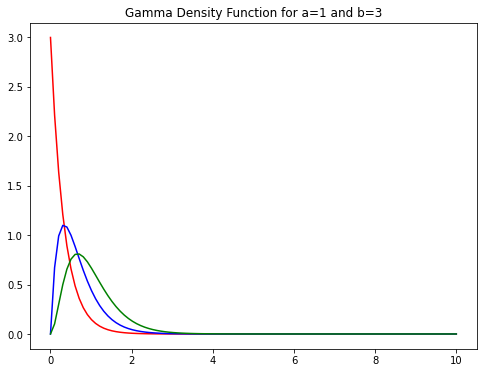

In [23]:
# Parameters of the prior gamma distribution.
a = 1 # shape
b = 3 # rate = 1/scale

c = 2
d = 3

e = 3
f = 3

x = np.linspace(start=0, stop=10, num=100)

plt.figure(figsize=(8, 6))
plt.plot(x, ss.gamma.pdf(x,a=a,scale=1/b), 'r-')
plt.plot(x, ss.gamma.pdf(x,a=c,scale=1/d), 'b-')
plt.plot(x, ss.gamma.pdf(x,a=e,scale=1/f), 'g-')
plt.title('Gamma Density Function for a={} and b={}'.format(a,b))

# Define the prior distribution.
prior = lambda x: ss.gamma.pdf(x, a=a, scale=1/b)

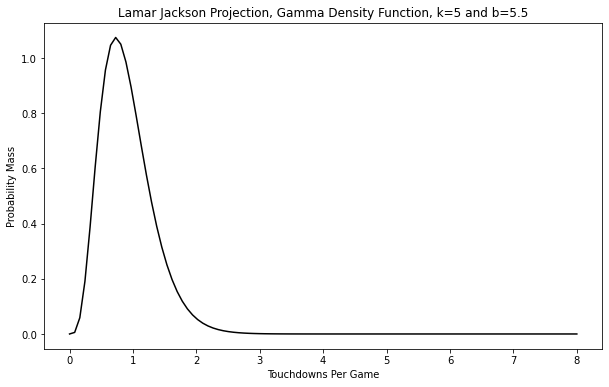

In [24]:
# Parameters of the prior gamma distribution.
k = 5 # shape
b = 5.5 # rate = 1/scale

x = np.linspace(start=0, stop=8, num=100)

plt.figure(figsize=(10, 6))
plt.plot(x, ss.gamma.pdf(x,a=k,scale=1/b), 'k-')
plt.title('Lamar Jackson Projection, Gamma Density Function, k={} and b={}'.format(k,b))

plt.xlabel("Touchdowns Per Game")
plt.ylabel("Probability Mass")
plt.show()

In [25]:
import scipy.special as sp

# Define the likelihood function.
def likelihood(lam,y):
    
    factorials = np.apply_along_axis(
        lambda x: sp.gamma(x+1),
        axis=0,
        arr=y
    )
    
    numerator = np.exp(-lam*y.size)*(lam**y.sum())
    
    denominator = np.multiply.reduce(factorials)
    
    return numerator/denominator

2.3076923076923075


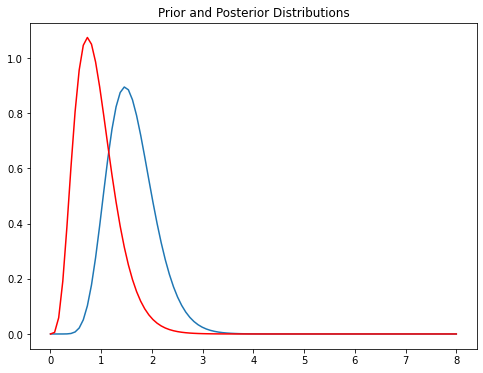

In [26]:
def posterior(lam,y):
    
    shape = k + y.sum()
    rate = b + y.size
    
    return ss.gamma.pdf(lam, shape, scale=1/rate), shape, rate

y = np.array([5, 2, 0, 3, 1, 0, 0, 1, 3, 4, 5, 1, 3, 5, 3, 1])

week=3

y_hat = y[:week-1]

print(np.mean(y[week:]))

y, shape, rate = posterior(x,y_hat)

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(x, ss.gamma.pdf(x,a=k,scale=1/b), 'r-')
plt.title('Prior and Posterior Distributions');

fig size: 72.0 DPI, size in inches [6. 4.]


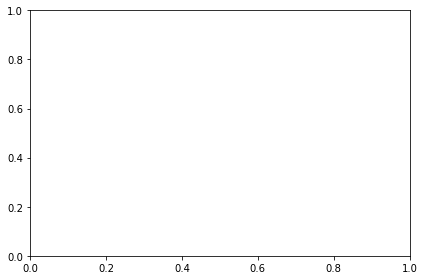

In [27]:
from matplotlib.animation import FuncAnimation, HTMLWriter
import sys

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))


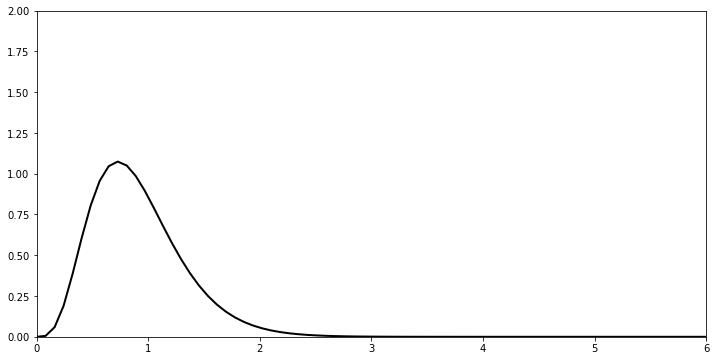

In [28]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 2))

prior, = ax.plot(x, ss.gamma.pdf(x,a=k,scale=1/b), lw=2, color='black')
post, = ax.plot([], [], lw=2, color='purple')

def init():
    post.set_data([], [])
    return post,

def animate(i):
    x = np.linspace(0, 6, 500)
    week=i 
    samples = np.array([5, 2, 0, 3, 1, 0, 0, 1, 3, 4, 5, 1, 3, 5, 3])
    y_hat = samples[:week]
    y, shape, rate = posterior(x,y_hat)
    post.set_data(x, y)
    
    print("week {}, shape: ", shape, "rate: ", rate)
    
    plt.title("Lamar Jackson Posterior After {} games".format(i))
    
    plt.xlabel("Touchdowns Per Game")
    plt.ylabel("Probability Mass")
    
    return post,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=16, interval=250, blit=True)


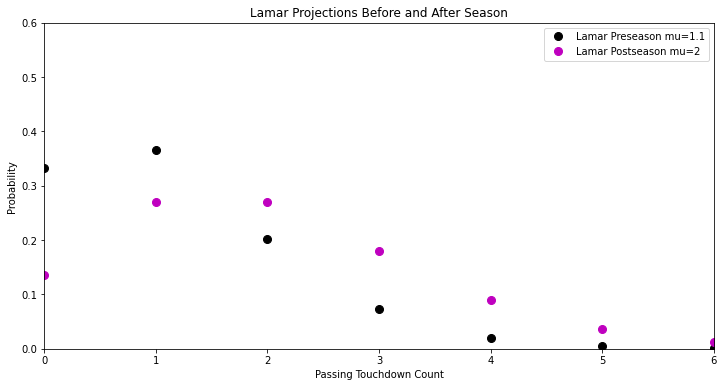

In [29]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.1
mu2 = 2
# get x values
x = np.arange(0, 7)
ax.set_title("Lamar Projections Before and After Season")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='Lamar Preseason mu=1.1')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='Lamar Postseason mu=2')
ax.legend()

In [ ]:
import scipy.stats as ss
import numpy as np
# k = shape parameter (found above)
# b = rate parameter
# 100 decimals between 0 and 8 to create a smooth line
x = np.linspace(start=0, stop=8, num=100) 
# y = np.array([ ... season touchdown counts ])
def posterior(x,y):
    shape = k + y.sum()
    rate = b + y.size
    
    return ss.gamma.pdf(x, shape, scale=1/rate), shape, rate

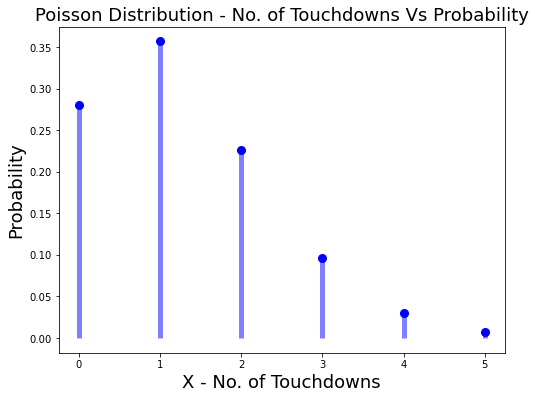

In [140]:
# Random variable representing number of touchdowns
# Mean number of occurences of touchdowns per game is 1.27 across all seasons all QBs 
#
X = [0, 1, 2, 3, 4, 5]
lmbda = 1.27
#
# Probability values
#
poisson_pd = poisson.pmf(X, lmbda)
#
# Plot the probability distribution
#
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(X, poisson_pd, 'bo', ms=8, label='poisson pmf')
plt.ylabel("Probability", fontsize="18")
plt.xlabel("X - No. of Touchdowns", fontsize="18")
plt.title("Poisson Distribution - No. of Touchdowns Vs Probability", fontsize="18")
ax.vlines(X, 0, poisson_pd, colors='b', lw=5, alpha=0.5)

In [142]:
#get where position is qb only Josh Allen
td_pg_josh_allen = td_pg[(td_pg.player == "Josh Allen")]
print(td_pg_josh_allen)

    season      player  pass_td  game_id     td_pg
5     2021  Josh Allen       45       19  2.368421
7     2020  Josh Allen       42       19  2.210526
20    2022  Josh Allen       32       15  2.133333


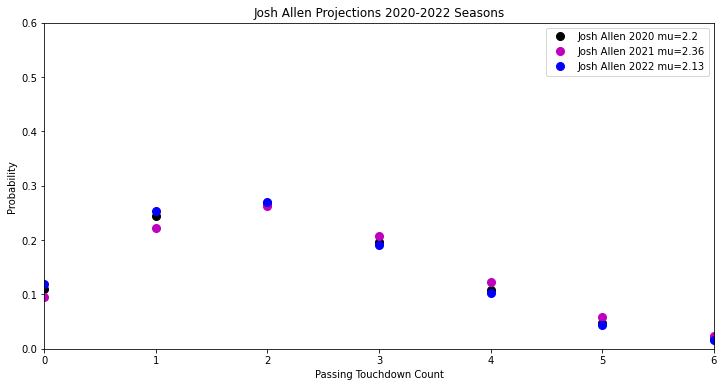

In [145]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 2.2
mu2 = 2.36
mu3=2.13
# get x values
x = np.arange(0, 7)
ax.set_title("Josh Allen Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='Josh Allen 2020 mu=2.2')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='Josh Allen 2021 mu=2.36')
ax.plot(x, ss.poisson.pmf(x, mu3), 'bo', ms=8, label='Josh Allen 2022 mu=2.13')
ax.legend()

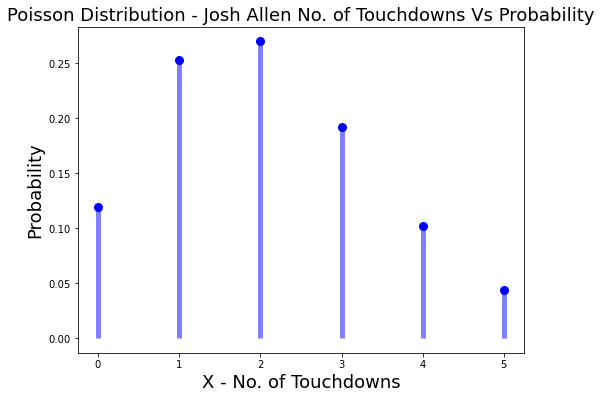

In [146]:
# Random variable representing number of touchdowns
# Mean number of occurences of touchdowns per game is 1.27 across all seasons all QBs 
#
X = [0, 1, 2, 3, 4, 5]
lmbda = 2.13
#
# Probability values
#
poisson_pd = poisson.pmf(X, lmbda)
#
# Plot the probability distribution
#
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(X, poisson_pd, 'bo', ms=8, label='poisson pmf')
plt.ylabel("Probability", fontsize="18")
plt.xlabel("X - No. of Touchdowns", fontsize="18")
plt.title("Poisson Distribution - Josh Allen No. of Touchdowns Vs Probability", fontsize="18")
ax.vlines(X, 0, poisson_pd, colors='b', lw=5, alpha=0.5)

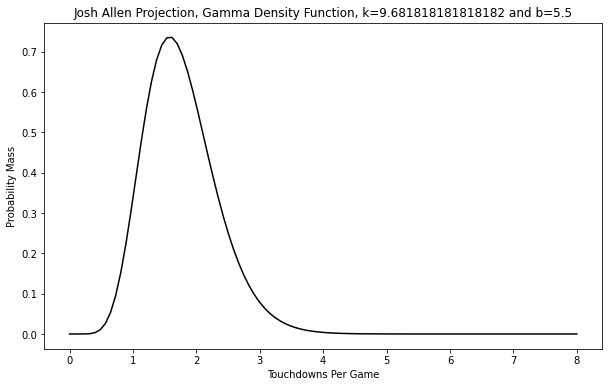

In [148]:
# theta = mu/0.22
# k = mu * theta
# Parameters of the prior gamma distribution.
k = 2.13/.22
b = 5.5 # rate = 1/scale

x = np.linspace(start=0, stop=8, num=100)

plt.figure(figsize=(10, 6))
plt.plot(x, ss.gamma.pdf(x,a=k,scale=1/b), 'k-')
plt.title('Josh Allen Projection, Gamma Density Function, k={} and b={}'.format(k,b))

plt.xlabel("Touchdowns Per Game")
plt.ylabel("Probability Mass")
plt.show()

In [152]:
#get where position is qb only Josh Allen
td_pg_trevor_lawrence = td_pg[(td_pg.player == "Trevor Lawrence")]
print(td_pg_trevor_lawrence)

    season           player  pass_td  game_id     td_pg
40    2022  Trevor Lawrence       24       15  1.600000
78    2021  Trevor Lawrence       12       17  0.705882


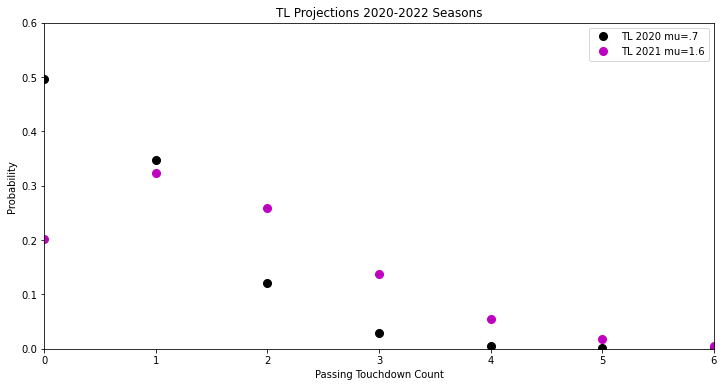

In [154]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = .7
mu2 = 1.6

# get x values
x = np.arange(0, 7)
ax.set_title("TL Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='TL 2020 mu=.7')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='TL 2021 mu=1.6')
ax.legend()

In [155]:
#get where position is qb only mac jones 
td_pg_mac_jones = td_pg[(td_pg.player == "Mac Jones")]
print(td_pg_mac_jones)

    season     player  pass_td  game_id     td_pg
39    2021  Mac Jones       24       18  1.333333
92    2022  Mac Jones        9       12  0.750000


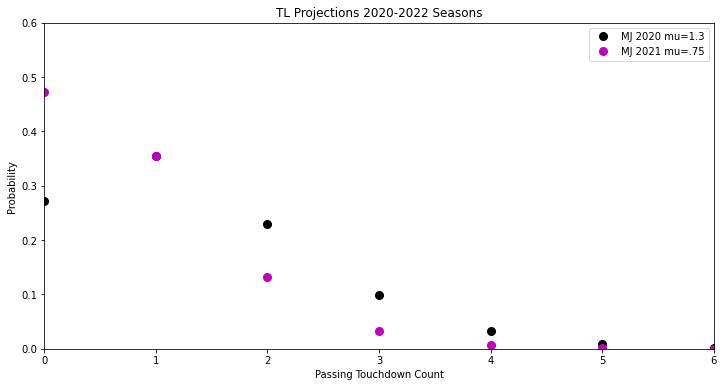

In [156]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.3
mu2 = .75

# get x values
x = np.arange(0, 7)
ax.set_title("TL Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='MJ 2020 mu=1.3')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='MJ 2021 mu=.75')
ax.legend()

In [157]:
#get where position is qb only Joe Burrow
td_pg_joe_burrow = td_pg[(td_pg.player == "Joe Burrow")]
print(td_pg_joe_burrow)

    season      player  pass_td  game_id     td_pg
17    2022  Joe Burrow       34       15  2.266667
9     2021  Joe Burrow       39       20  1.950000
77    2020  Joe Burrow       13       10  1.300000


Joe Burrow has a 65.0% chance of throwing for 2 or more touchdowns


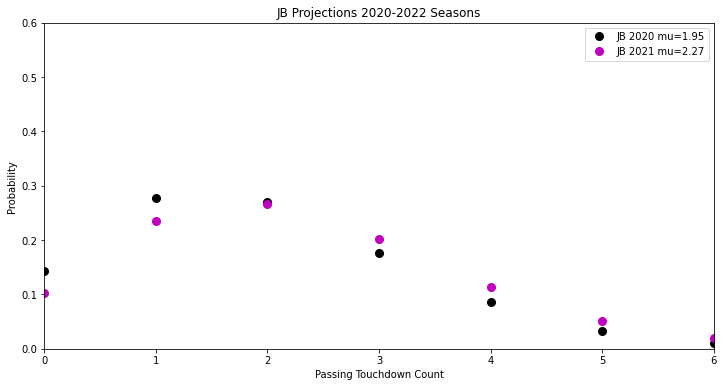

In [32]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.95
mu2 = 2.27

# get x values
x = np.arange(0, 7)
ax.set_title("JB Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='JB 2020 mu=1.95')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='JB 2021 mu=2.27')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2)
print("Joe Burrow has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

In [193]:
#get where position is qb only Kirk Cousins
td_pg_kirk_cousins = td_pg[(td_pg.player == "Kirk Cousins")]
print(td_pg_kirk_cousins)

    season        player  pass_td  game_id   td_pg
15    2020  Kirk Cousins       35       16  2.1875
19    2021  Kirk Cousins       33       16  2.0625
23    2022  Kirk Cousins       27       15  1.8000


Kirk Cousins has a 53.0% chance of throwing for 2 or more touchdowns
Kirk Cousins has a 27.0% chance of throwing for 3 or more touchdowns


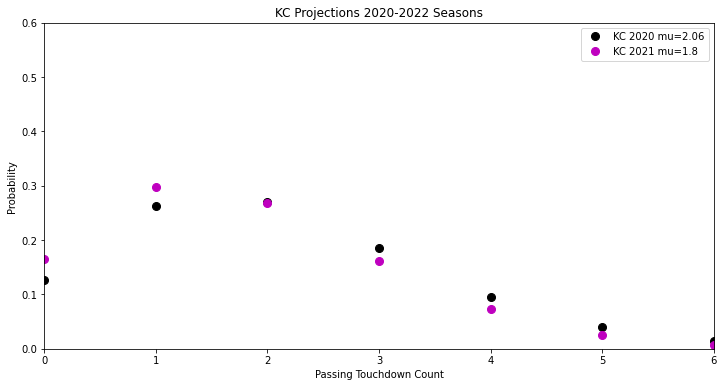

In [210]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1_kc = 2.06
mu2_kc = 1.8

# get x values
x = np.arange(0, 7)
ax.set_title("KC Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1_kc), 'ko', ms=8, label='KC 2020 mu=2.06')
ax.plot(x, ss.poisson.pmf(x, mu2_kc), 'mo', ms=8, label='KC 2021 mu=1.8')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2_kc)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2_kc)
print("Kirk Cousins has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

prob_array = ss.poisson.pmf(x, mu2_kc)
jg_prob = np.round(prob_array[3:].sum(),2) * 100

ss.poisson.pmf(x, mu2_kc)
print("Kirk Cousins has a {}% chance of throwing for 3 or more touchdowns".format(jg_prob))

In [162]:
#get where position is qb only Kenny Pickett
td_pg_kenny_pickett = td_pg[(td_pg.player == "Kenny Pickett")]
print(td_pg_kenny_pickett)

     season         player  pass_td  game_id     td_pg
108    2022  Kenny Pickett        5       11  0.454545


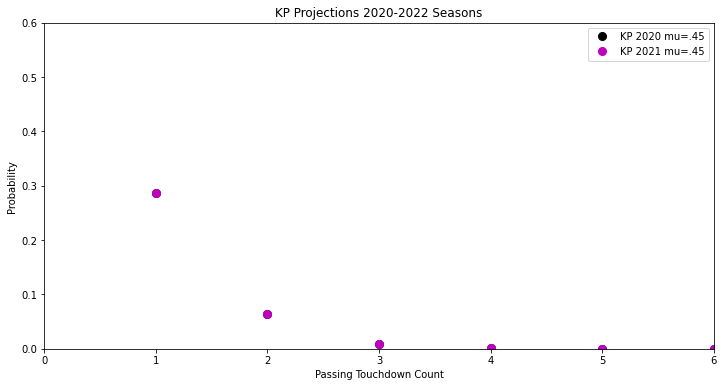

In [163]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = .45
mu2 = .45

# get x values
x = np.arange(0, 7)
ax.set_title("KP Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='KP 2020 mu=.45')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='KP 2021 mu=.45')
ax.legend()

In [164]:
#get where position is qb only Andy Dalton
td_pg_andy_dalton = td_pg[(td_pg.player == "Andy Dalton")]
print(td_pg_andy_dalton)

    season       player  pass_td  game_id     td_pg
57    2022  Andy Dalton       17       12  1.416667
73    2020  Andy Dalton       14       11  1.272727
97    2021  Andy Dalton        8        8  1.000000


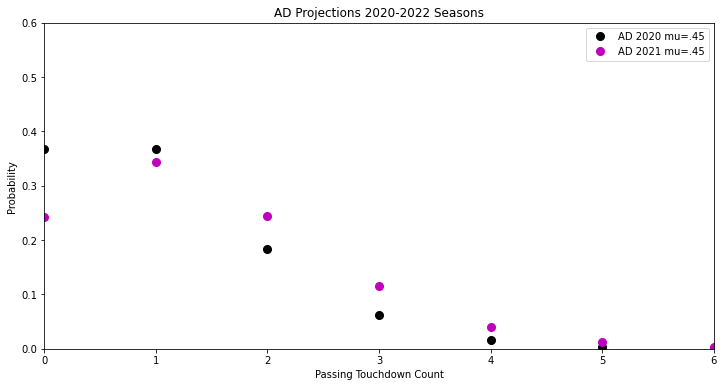

In [165]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1
mu2 = 1.42

# get x values
x = np.arange(0, 7)
ax.set_title("AD Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='AD 2020 mu=.45')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='AD 2021 mu=.45')
ax.legend()

In [166]:
#get where position is qb only Davis Mills
td_pg_davis_mills = td_pg[(td_pg.player == "Davis Mills")]
print(td_pg_davis_mills)

    season       player  pass_td  game_id     td_pg
66    2021  Davis Mills       16       13  1.230769
71    2022  Davis Mills       14       13  1.076923


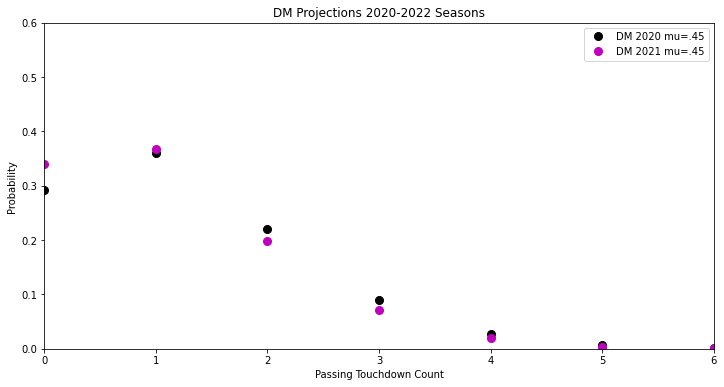

In [167]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.23
mu2 = 1.08

# get x values
x = np.arange(0, 7)
ax.set_title("DM Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='DM 2020 mu=.45')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='DM 2021 mu=.45')
ax.legend()

In [198]:
#get where position is qb only Deshaun Watson
td_pg_dw = td_pg[(td_pg.player == "Deshaun Watson")]
print(td_pg_dw)

    season          player  pass_td  game_id   td_pg
18    2020  Deshaun Watson       33       16  2.0625


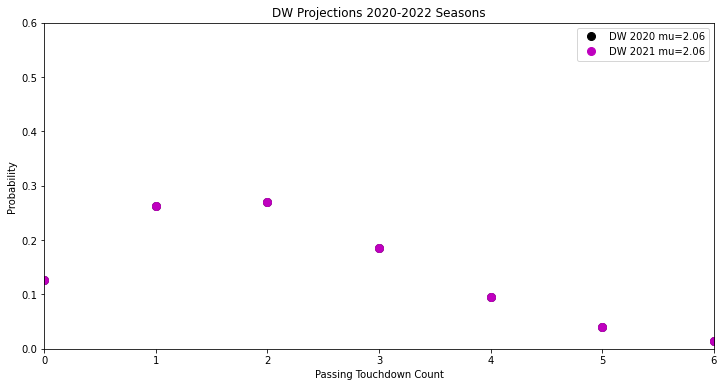

In [201]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 2.06
mu2_dw = 2.06

# get x values
x = np.arange(0, 7)
ax.set_title("DW Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='DW 2020 mu=2.06')
ax.plot(x, ss.poisson.pmf(x, mu2_dw), 'mo', ms=8, label='DW 2021 mu=2.06')
ax.legend()

#ss.poisson.pmf(x, mu2_dw)
#print("Dashuan Watson has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

In [170]:
#get where position is qb only Baker Mayfield
td_pg_bm = td_pg[(td_pg.player == "Baker Mayfield")]
print(td_pg_bm)

    season          player  pass_td  game_id     td_pg
22    2020  Baker Mayfield       30       18  1.666667
54    2021  Baker Mayfield       17       14  1.214286
87    2022  Baker Mayfield       10       10  1.000000


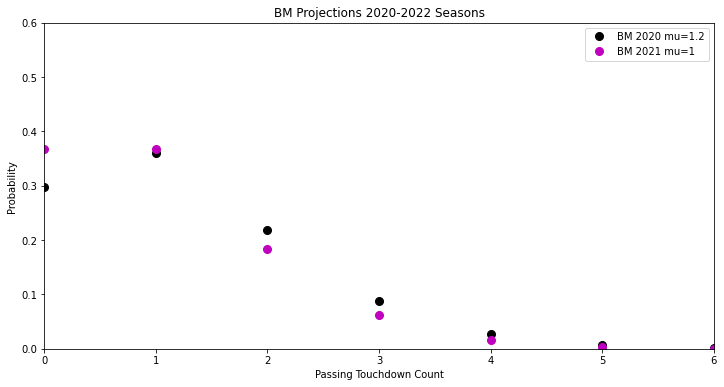

In [174]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.21
mu2 =1

# get x values
x = np.arange(0, 7)
ax.set_title("BM Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='BM 2020 mu=1.2')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='BM 2021 mu=1')
ax.legend()

In [173]:
#get where position is qb only Geno Smith 
td_pg_gs = td_pg[(td_pg.player == "Geno Smith")]
print(td_pg_gs)

    season      player  pass_td  game_id  td_pg
25    2022  Geno Smith       27       15    1.8


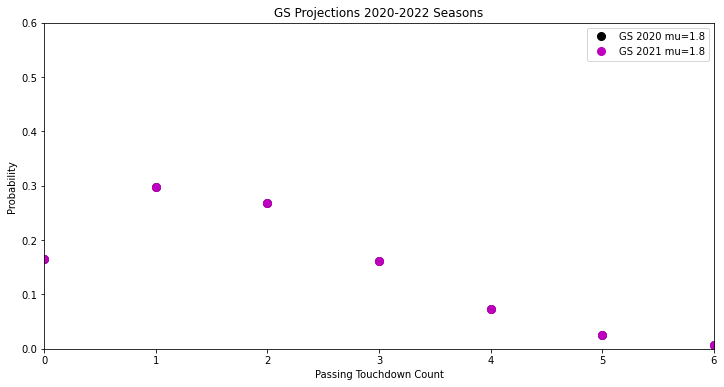

In [176]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.8
mu2 =1.8

# get x values
x = np.arange(0, 7)
ax.set_title("GS Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='GS 2020 mu=1.8')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='GS 2021 mu=1.8')
ax.legend()

In [189]:
ss.poisson.pmf(x, 1.8)
print("Geno Smith has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

Geno Smith has a 51.0% chance of throwing for 2 or more touchdowns


In [177]:
#get where position is qb only Russell Wilson
td_pg_rw = td_pg[(td_pg.player == "Russell Wilson")]
print(td_pg_rw)

    season          player  pass_td  game_id     td_pg
8     2020  Russell Wilson       42       17  2.470588
35    2021  Russell Wilson       25       14  1.785714
79    2022  Russell Wilson       12       13  0.923077


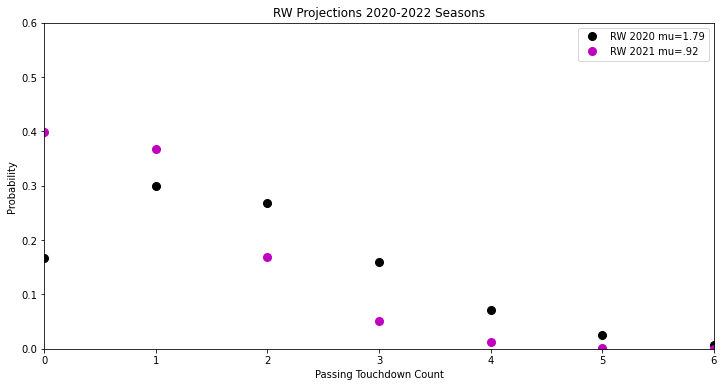

In [178]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.79
mu2 =.92

# get x values
x = np.arange(0, 7)
ax.set_title("RW Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='RW 2020 mu=1.79')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='RW 2021 mu=.92')
ax.legend()

In [181]:
#get where position is qb only Aaron Rogers
td_pg_ar = td_pg[(td_pg.player == "Aaron Rodgers")]
print(td_pg_ar)

    season         player  pass_td  game_id     td_pg
0     2020  Aaron Rodgers       53       18  2.944444
13    2021  Aaron Rodgers       37       17  2.176471
37    2022  Aaron Rodgers       24       15  1.600000


Aaron Rodgers has a 47.0% chance of throwing for 2 or more touchdowns


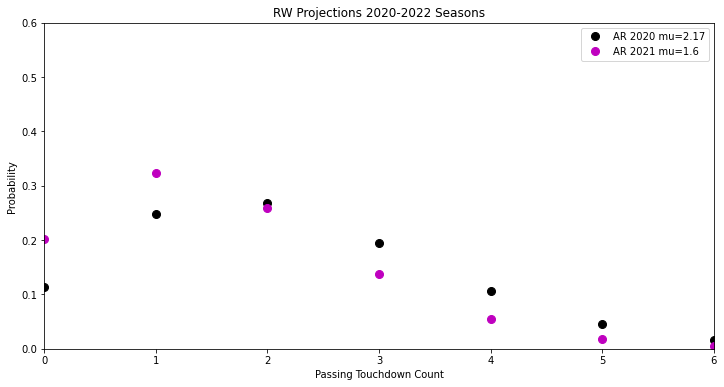

In [184]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 2.17
mu2 =1.6

# get x values
x = np.arange(0, 7)
ax.set_title("RW Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='AR 2020 mu=2.17')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='AR 2021 mu=1.6')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2)
print("Aaron Rodgers has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

In [185]:
#get where position is qb only Jared Goff
td_pg_jg = td_pg[(td_pg.player == "Jared Goff")]
print(td_pg_jg)

    season      player  pass_td  game_id     td_pg
33    2022  Jared Goff       26       15  1.733333
52    2021  Jared Goff       19       14  1.357143
43    2020  Jared Goff       22       17  1.294118


Jared Goff has a 51.0% chance of throwing for 2 or more touchdowns


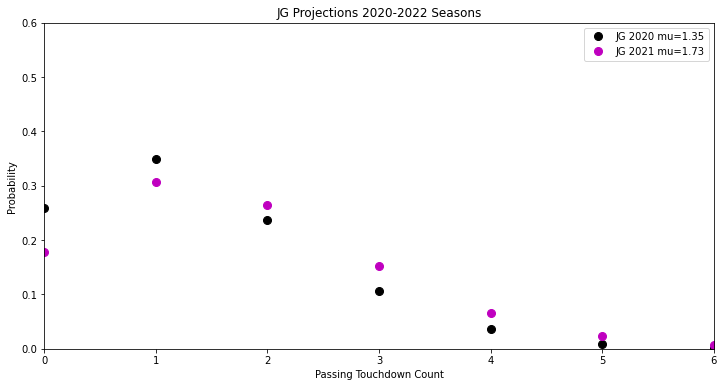

In [187]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.35
mu2 =1.73

# get x values
x = np.arange(0, 7)
ax.set_title("JG Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='JG 2020 mu=1.35')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='JG 2021 mu=1.73')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2)
print("Jared Goff has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

In [190]:
#get where position is qb only Daniel Jones
td_pg_dj = td_pg[(td_pg.player == "Daniel Jones")]
print(td_pg_dj)

    season        player  pass_td  game_id     td_pg
89    2021  Daniel Jones       10       11  0.909091
75    2022  Daniel Jones       13       15  0.866667
85    2020  Daniel Jones       11       14  0.785714


Daniel Jones has a 21.0% chance of throwing for 2 or more touchdowns


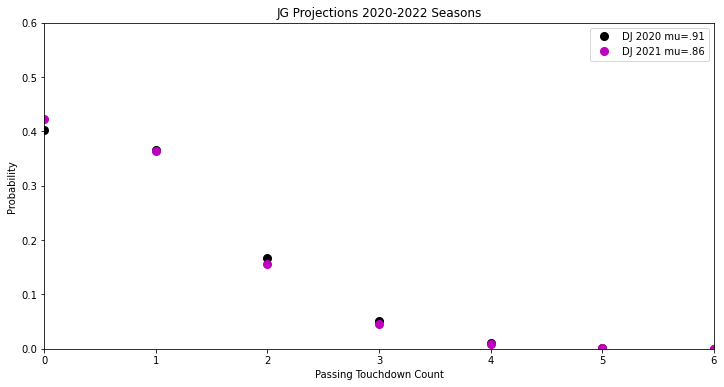

In [191]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = .91
mu2 =.86

# get x values
x = np.arange(0, 7)
ax.set_title("JG Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='DJ 2020 mu=.91')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='DJ 2021 mu=.86')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2)
print("Daniel Jones has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

In [30]:
#get where position is qb only Tom Brady
td_pg_tb = td_pg[(td_pg.player == "Tom Brady")]
print(td_pg_tb)

    season     player  pass_td  game_id     td_pg
1     2020  Tom Brady       50       20  2.500000
4     2021  Tom Brady       46       19  2.421053
47    2022  Tom Brady       21       15  1.400000


Tom Brady has a 41.0% chance of throwing for 2 or more touchdowns


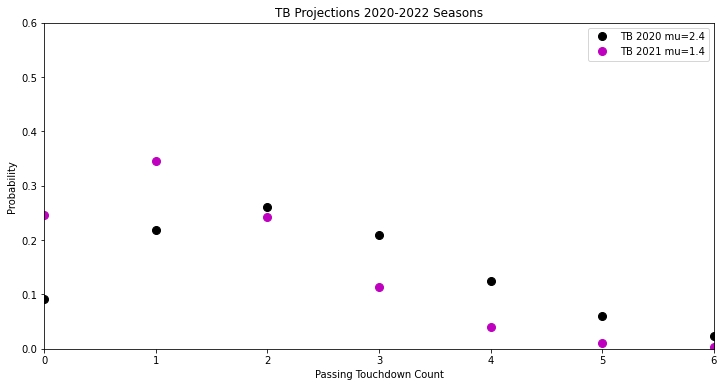

In [31]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 2.4
mu2 =1.4

# get x values
x = np.arange(0, 7)
ax.set_title("TB Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='TB 2020 mu=2.4')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='TB 2021 mu=1.4')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2)
print("Tom Brady has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

In [33]:
#get where position is qb only Jalen Hurts 
td_pg_jh = td_pg[(td_pg.player == "Jalen Hurts")]
print(td_pg_jh)

     season       player  pass_td  game_id     td_pg
46     2022  Jalen Hurts       22       14  1.571429
55     2021  Jalen Hurts       17       16  1.062500
106    2020  Jalen Hurts        6       14  0.428571


Jalen Hurts has a 28.999999999999996% chance of throwing for 2 or more touchdowns


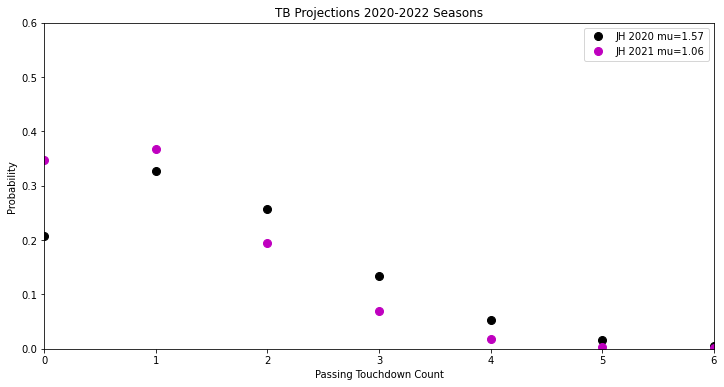

In [34]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 1.57
mu2 =1.06

# get x values
x = np.arange(0, 7)
ax.set_title("TB Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='JH 2020 mu=1.57')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='JH 2021 mu=1.06')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2)
print("Jalen Hurts has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))

In [35]:
#get where position is qb only Mahomes 
td_pg_pm = td_pg[(td_pg.player == "Patrick Mahomes")]
print(td_pg_pm)

    season           player  pass_td  game_id     td_pg
14    2022  Patrick Mahomes       37       15  2.466667
3     2021  Patrick Mahomes       48       20  2.400000
6     2020  Patrick Mahomes       42       18  2.333333


Patrick Mahomes has a 69.0% chance of throwing for 2 or more touchdowns


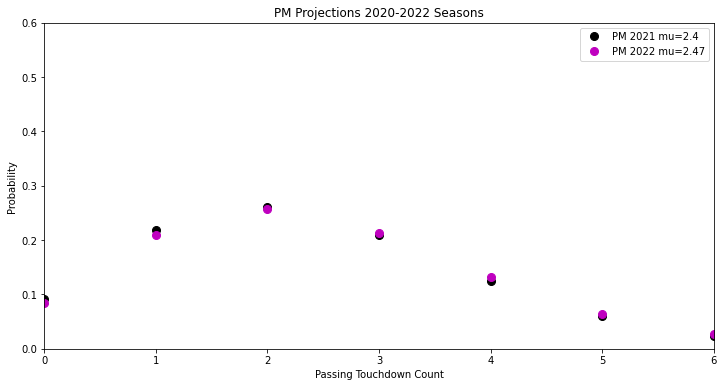

In [36]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(0, 6), ylim=(0, 0.6))
# average, and for poisson, also variance
mu1 = 2.4
mu2 =2.47

# get x values
x = np.arange(0, 7)
ax.set_title("PM Projections 2020-2022 Seasons")
ax.set_xlabel("Passing Touchdown Count")
ax.set_ylabel("Probability")
ax.plot(x, ss.poisson.pmf(x, mu1), 'ko', ms=8, label='PM 2021 mu=2.4')
ax.plot(x, ss.poisson.pmf(x, mu2), 'mo', ms=8, label='PM 2022 mu=2.47')
ax.legend()

prob_array = ss.poisson.pmf(x, mu2)
jg_prob = np.round(prob_array[2:].sum(),2) * 100

ss.poisson.pmf(x, mu2)
print("Patrick Mahomes has a {}% chance of throwing for 2 or more touchdowns".format(jg_prob))